In [2]:
#Import necessary modules
import os
import sys
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import walk
from os.path import splitext
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import graphviz
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve

The function below gets the data for single Modalities and concatenates them to a dataframe

In [1]:
def get_Data(feature):
    data = "C:/Users/Jad Maaloulz/data/" + feature
    li = []
    #Extract feature and target np arrays (inputs for placeholders)
    for root, dirs, files in walk(data):
        for f in files:
            if splitext(f)[1].lower() == ".csv":
                if(os.path.exists(data+'/'+f)):
                    df = pd.read_csv(data+'/'+f, index_col=None, header=0)
                    temp = df['label'].iloc[0]
                    df = df.mean(axis = 0).to_frame().transpose()
                    df['label'] = temp
                    li.append(df)


    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

This function gets the Data for all Modalities and concatenates them in a single dataframe

In [2]:
def get_All_Data():
    data_gaze = "C:/Users/Jad Maaloulz/data/Gaze_Features"
    data_mexp = "C:/Users/Jad Maaloulz/data/Mexp_Features"
    data_audio = "C:/Users/Jad Maaloulz/data/Audio_Features/csv_framewise_audio"
    li_gaze = []
    li_mexp = []
    li_audio = []
    #Extract feature and target np arrays (inputs for placeholders)
    for root, dirs, files in walk(data_gaze):
        for f in files:
            if splitext(f)[1].lower() == ".csv":
                if(os.path.exists(data_gaze+'/'+f)):
                    df_gaze = pd.read_csv(data_gaze+'/'+f, index_col=None, header=0)
                    df_mexp = pd.read_csv(data_mexp+'/Mexp_'+f.split('_', 1)[1], index_col=None, header=0)
                    df_audio = pd.read_csv(data_audio+'/Audio_'+f.split('_', 1)[1], index_col=None, header=0)

                    temp = df_audio['label'].iloc[0]

                    df_gaze = df_gaze.mean(axis = 0).to_frame().transpose()
                    df_mexp = df_mexp.mean(axis = 0).to_frame().transpose()
                    df_audio = df_audio.mean(axis = 0).to_frame().transpose()

                    df_audio['label'] = temp
                    li_gaze.append(df_gaze)
                    li_mexp.append(df_mexp)
                    li_audio.append(df_audio)



    frame_gaze = pd.concat(li_gaze, axis=0, ignore_index=True)
    frame_mexp = pd.concat(li_mexp, axis=0, ignore_index=True)
    frame_audio = pd.concat(li_audio, axis=0, ignore_index=True)
    return pd.concat([frame_gaze.iloc[:,6:14],frame_mexp.iloc[:,6:47],frame_audio.iloc[:,2:28],frame_audio.iloc[:,28]] , axis=1)

This function normalizes our data

In [3]:
def normalize(x):
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X_norm = pd.DataFrame(x_scaled)
    return X_norm

This function will encode our labels to 0 for deceptive and 1 Truthful

In [34]:
def encoder(x):
    le = preprocessing.LabelEncoder()
    le.fit(["Truthful", "Deceptive"])
    list(le.classes_)
    return le.transform(x)


This function takes care of splitting the data into trainin sets and test sets while also using smote for oversampling

In [35]:
def data_Split(X_norm,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=0)
    sm = SMOTE(random_state=42)
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
    return X_train_res, X_test, Y_train_res, Y_test

__#################################################__

# Gaze Model

__#################################################__

In [14]:
frame_gaze = get_Data('Gaze_Features') #Fetches our data specifically for gaze

In [15]:
X_gaze_norm = normalize(frame_gaze.iloc[:,6:14].values) #normalization
X_gaze_norm.head()

,0,1,2,3,4,5,6,7
0,0.645981,0.833377,0.147518,0.484168,0.828999,0.151599,0.562146,0.810759
1,0.640654,0.839265,0.148651,0.473654,0.829310,0.154038,0.553946,0.814694
2,0.626557,0.778500,0.123944,0.480465,0.773122,0.131945,0.550101,0.748673
3,0.644823,0.813580,0.140539,0.490275,0.803699,0.141933,0.564455,0.785835
4,0.622857,0.799721,0.131182,0.468474,0.795251,0.143994,0.542067,0.773802


Applying RandomForestClassifier

In [18]:
Y_gaze = encoder(frame_gaze.iloc[:,294].values)
X_train_gaze, X_test_gaze, Y_train_gaze, Y_test_gaze = data_Split(X_gaze_norm, Y_gaze)
regressor_gaze = RandomForestClassifier(n_estimators = 100 , max_depth = 4 , random_state=0)
regresor_score_gaze = cross_validate(regressor_gaze, X_gaze_norm, Y_gaze, cv=5 , scoring=('accuracy', 'roc_auc','f1')) # crossvalidation used with 5 folds
regressor_gaze.fit(X_train_gaze, Y_train_gaze) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Mean Absolute Error: 0.33 degrees.
0.6692015209125475


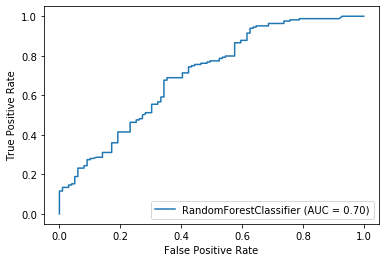

In [19]:
y_pred_gaze = regressor_gaze.predict(X_test_gaze)
errors = abs(y_pred_gaze - Y_test_gaze)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print(regressor_gaze.score(X_test_gaze, Y_test_gaze))

ax = plt.gca()
gaze_disp = plot_roc_curve(regressor_gaze, X_test_gaze, Y_test_gaze, ax=ax, alpha=1)

#precision_recall_curve(Y_test_gaze, y_pred_gaze)



In [20]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_pred_gaze, Y_test_gaze))
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean Acc Score - Random Forest: ", regresor_score_gaze['test_accuracy'].mean())
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", regresor_score_gaze['test_roc_auc'].mean())
print('\n')
print("=== Mean F1 Score ===")
print("Mean f1 Score - Random Forest: ", regresor_score_gaze['test_f1'].mean())

=== Confusion Matrix ===
[[ 45  33]
 [ 54 131]]


=== Mean Accuracy Score ===
Mean Acc Score - Random Forest:  0.619092676980234


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6428230103230103


=== Mean F1 Score ===
Mean f1 Score - Random Forest:  0.7164657020282512


__#################################################__

# MExp model

__#################################################__

In [13]:
frame_mexp = get_Data('Mexp_Features') #Fetches our data for the mexp

In [14]:
X_mexp_norm = normalize(frame_mexp.iloc[:,6:47].values) #normalization of the data
X_mexp_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.999973,0.999986,0.000006,0.660474,0.414960,0.452860,0.033702,0.053215,0.161948,0.092264,...,0.375510,1.0,0.000000,0.030252,0.000000,0.085714,0.518316,0.177837,0.0,0.227947
1,0.999974,0.999986,0.000006,0.668103,0.431913,0.430737,0.056577,0.102579,0.097703,0.149650,...,0.872038,1.0,0.084016,0.250906,0.075829,0.180095,0.633511,0.363822,0.0,0.264678
2,0.999974,0.999985,0.000006,0.623989,0.435274,0.448571,0.030251,0.048255,0.121823,0.077485,...,0.779221,1.0,0.000000,0.279603,0.000000,0.000000,0.643761,0.458065,0.0,0.224493
3,0.999973,0.999985,0.000006,0.636384,0.447401,0.453576,0.043123,0.051018,0.093482,0.113505,...,0.914286,1.0,0.000000,0.191597,0.000000,0.071429,0.302351,0.207477,0.0,0.332423
4,0.999974,0.999985,0.000006,0.630775,0.420291,0.414108,0.041531,0.060616,0.097485,0.087166,...,0.856287,1.0,0.000000,0.234590,0.000000,0.155689,0.640340,0.223628,0.0,0.382186


Applying RandomForestClassifier

In [113]:
Y_mexp = encoder(frame_mexp.iloc[:,47].values)
X_train_mexp, X_test_mexp, Y_train_mexp, Y_test_mexp = data_Split(X_mexp_norm, Y_mexp) 
regressor_mexp = RandomForestClassifier(n_estimators = 100 , max_depth = 4 , random_state=0)
regresor_score_mexp = cross_validate(regressor_mexp, X_mexp_norm, Y_mexp, cv=7 , scoring=('accuracy', 'roc_auc','f1')) # crossvalidation used with 7 folds
regressor_mexp.fit(X_train_mexp, Y_train_mexp) 


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Mean Absolute Error: 0.34 degrees.
0.6590909090909091


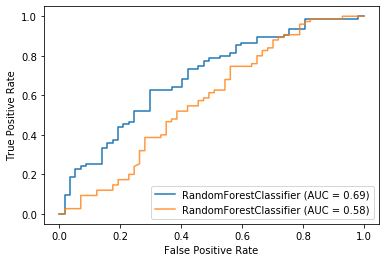

In [114]:
y_pred_mexp = regressor_mexp.predict(X_test_mexp)

errors = abs(y_pred_mexp - Y_test_mexp)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print(regressor_mexp.score(X_test_mexp, Y_test_mexp))


ax = plt.gca()
mexp_disp = plot_roc_curve(regressor_mexp, X_test_mexp, Y_test_mexp, ax=ax, alpha=1)
gaze_disp.plot(ax=ax, alpha=0.8)
plt.show()

#svc_disp.plot(ax=ax, alpha=0.8)
#plt.show()


In [115]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_pred_mexp, Y_test_mexp))
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean AUC Score - Random Forest: ", regresor_score_mexp['test_accuracy'].mean())
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", regresor_score_mexp['test_roc_auc'].mean())
print('\n')
print("=== Mean F1 Score ===")
print("Mean AUC Score - Random Forest: ", regresor_score_mexp['test_f1'].mean())

=== Confusion Matrix ===
[[40 28]
 [17 47]]


=== Mean Accuracy Score ===
Mean AUC Score - Random Forest:  0.5238095238095238


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.5554527117943182


=== Mean F1 Score ===
Mean AUC Score - Random Forest:  0.5817884108290742


__#################################################__

# Audio model

__#################################################__

In [18]:
frame_audio = get_Data('Audio_Features/csv_framewise_audio') #Fetches audio data

In [19]:
X_audio_norm = normalize(frame_audio.iloc[:,2:28].values) #normalization
X_audio_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000892,0.089964,0.706160,0.596271,0.548759,0.673054,0.507692,0.603958,0.296251,0.656157,...,0.229517,0.780941,0.549016,0.598014,0.376694,0.284306,0.152088,0.502426,0.477369,0.971072
1,0.000764,0.089242,0.666658,0.556063,0.528282,0.651599,0.528910,0.609678,0.275653,0.704502,...,0.250192,0.806479,0.526130,0.571989,0.370488,0.270194,0.196848,0.422436,0.255733,0.995823
2,0.014504,0.126318,0.681346,0.640214,0.573712,0.642483,0.498018,0.681848,0.269396,0.632868,...,0.267362,0.776339,0.546303,0.590342,0.414493,0.320672,0.167681,0.584247,0.495970,0.944239
3,0.001560,0.107648,0.652631,0.569034,0.534966,0.668106,0.495606,0.643365,0.294134,0.658395,...,0.183446,0.636962,0.450524,0.380403,0.181875,0.651546,0.198044,0.495306,0.460519,0.941602
4,0.001090,0.097025,0.637400,0.593191,0.518515,0.626322,0.465158,0.627648,0.313894,0.651563,...,0.243746,0.711678,0.483809,0.486708,0.260180,0.471683,0.233580,0.508367,0.500297,0.982786


Applying xgclassifier

In [20]:
Y_audio = encoder(frame_audio.iloc[:,28].values)
X_train_audio, X_test_audio, Y_train_audio, Y_test_audio = data_Split(X_audio_norm, Y_audio)

#dtest = xgb.DMatrix(X_test_audio, label=Y_test_audio)
#dtrain = xgb.DMatrix(X_train_audio, label=Y_train_audio)

#param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
#param['nthread'] = 4
#param['eval_metric'] = 'auc'

#evallist = [(dtest, 'eval'), (dtrain, 'train')]
regressor_audio = XGBClassifier(n_estimators = 100 , max_depth = 4 , random_state=0)
regresor_score_audio = cross_validate(regressor_audio, X_audio_norm, Y_audio, cv=5 , scoring=('accuracy', 'roc_auc','f1')) # crossvalidation used with 5
regressor_audio.fit(X_train_audio, Y_train_audio)
#bst = xgb.train(param, dtrain, 100, evallist)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Mean Absolute Error: 0.38 degrees.
0.6212121212121212


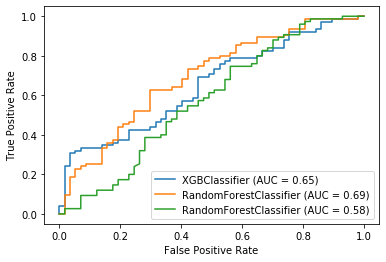

In [116]:
y_pred_audio = regressor_audio.predict(X_test_audio)

errors = abs(y_pred_audio - Y_test_audio)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print(regressor_audio.score(X_test_audio, Y_test_audio))



ax = plt.gca()
audio_disp = plot_roc_curve(regressor_audio, X_test_audio, Y_test_audio, ax=ax, alpha=1)
mexp_disp = plot_roc_curve(regressor_mexp, X_test_mexp, Y_test_mexp, ax=ax, alpha=1)
gaze_disp.plot(ax=ax, alpha=1)
plt.show()

In [22]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_pred_audio, Y_test_audio))
print('\n')
print("=== Mean Accuracy Score ===")
print("Mean AUC Score - XGB: ", regresor_score_audio['test_accuracy'].mean())
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGB: ", regresor_score_audio['test_roc_auc'].mean())
print('\n')
print("=== Mean F1 Score ===")
print("Mean AUC Score - XGB: ", regresor_score_audio['test_f1'].mean())

=== Confusion Matrix ===
[[31 24]
 [26 51]]


=== Mean Accuracy Score ===
Mean AUC Score - XGB:  0.5586513994910941


=== Mean AUC Score ===
Mean AUC Score - XGB:  0.5244041272114799


=== Mean F1 Score ===
Mean AUC Score - XGB:  0.5974018303377086


__#################################################__

# Audio + Gaze + mexp

__#################################################__

In [46]:
frame_mod = get_All_Data() # fetching all data

In [47]:
X_mod_norm = normalize(frame_mod.iloc[:,0:75].values) #normalization
X_mod_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.645981,0.833377,0.147518,0.484168,0.828999,0.151599,0.562146,0.810759,0.999973,0.999986,...,0.229517,0.780941,0.549016,0.598014,0.376694,0.284306,0.152088,0.502426,0.477369,0.971072
1,0.640654,0.839265,0.148651,0.473654,0.829310,0.154038,0.553946,0.814694,0.999974,0.999986,...,0.250192,0.806479,0.526130,0.571989,0.370488,0.270194,0.196848,0.422436,0.255733,0.995823
2,0.626557,0.778500,0.123944,0.480465,0.773122,0.131945,0.550101,0.748673,0.999974,0.999985,...,0.267362,0.776339,0.546303,0.590342,0.414493,0.320672,0.167681,0.584247,0.495970,0.944239
3,0.644823,0.813580,0.140539,0.490275,0.803699,0.141933,0.564455,0.785835,0.999973,0.999985,...,0.183446,0.636962,0.450524,0.380403,0.181875,0.651546,0.198044,0.495306,0.460519,0.941602
4,0.622857,0.799721,0.131182,0.468474,0.795251,0.143994,0.542067,0.773802,0.999974,0.999985,...,0.243746,0.711678,0.483809,0.486708,0.260180,0.471683,0.233580,0.508367,0.500297,0.982786


In [48]:
Y_mod = encoder(frame_mod.iloc[:,75].values) #encoding the label
X_train_mod, X_test_mod, Y_train_mod, Y_test_mod = data_Split(X_mod_norm, Y_mod) # spliting our data

Applying RandomForestClassifier for gaze

In [49]:
regressor_mod_gaze = RandomForestClassifier(n_estimators = 100 , max_depth = 4 , random_state=0)
regressor_mod_gaze.fit(X_train_mod.iloc[:,0:8], Y_train_mod) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [50]:
y_pred_mod_gaze = regressor_mod_gaze.predict_proba(X_test_mod.iloc[:,0:8])
y_pred_mod_gaze_1 = regressor_mod_gaze.predict(X_test_mod.iloc[:,0:8])

errors = abs(y_pred_mod_gaze_1 - Y_test_mod)
#Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, y_pred_mod_gaze_1))



Mean Absolute Error: 0.39 degrees.
Accuracy: 0.6060606060606061


RandomForest Classifier for mexp

In [51]:
regressor_mod_mexp = RandomForestClassifier(n_estimators = 100, random_state = 0)
regressor_mod_mexp.fit(X_train_mod.iloc[:,8:49], Y_train_mod) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [52]:
y_pred_mod_mexp = regressor_mod_mexp.predict_proba(X_test_mod.iloc[:,8:49])
y_pred_mod_mexp_1 = regressor_mod_mexp.predict(X_test_mod.iloc[:,8:49])

errors = abs(y_pred_mod_mexp_1 - Y_test_mod)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, y_pred_mod_mexp_1))



Mean Absolute Error: 0.36 degrees.
Accuracy: 0.6439393939393939


XGBClassifier for audio

In [53]:
regressor_mod_audio = XGBClassifier(n_estimators = 20, max_depth = 4, random_state = 0)
regressor_mod_audio.fit(X_train_mod.iloc[:,49:75], Y_train_mod)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [54]:
y_pred_mod_audio = regressor_mod_audio.predict_proba(X_test_mod.iloc[:,49:75])
y_pred_mod_audio_1 = regressor_mod_audio.predict(X_test_mod.iloc[:,49:75])

errors = abs(y_pred_mod_audio_1 - Y_test_mod)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, y_pred_mod_audio_1))

Mean Absolute Error: 0.39 degrees.
Accuracy: 0.6136363636363636


Manual Late Fusion for the different combination of modalities

In [57]:
li_prob = np.empty([y_pred_mod_gaze.shape[0],1])
li_prob_1 = np.empty([y_pred_mod_gaze.shape[0],1])
li_prob_2 = np.empty([y_pred_mod_gaze.shape[0],1])
li_prob_3 = np.empty([y_pred_mod_gaze.shape[0],1])

for i in range(0,y_pred_mod_gaze.shape[0]):
    li_prob[i]= (0.3 * y_pred_mod_audio[i][1])+(0.2 * y_pred_mod_gaze[i][1])+(0.5 * y_pred_mod_mexp[i][1]) # gaze + audio + mexp
    li_prob_1[i]= (0.4 * y_pred_mod_audio[i][1])+(0 * y_pred_mod_gaze[i][1])+(0.6 * y_pred_mod_mexp[i][1]) # audio + mexp
    li_prob_2[i]= (0 * y_pred_mod_audio[i][1])+(0.4 * y_pred_mod_gaze[i][1])+(0.6 * y_pred_mod_mexp[i][1]) # gaze + mexp
    li_prob_3[i]=(0.6 * y_pred_mod_audio[i][1])+(0.4 * y_pred_mod_gaze[i][1])+(0 * y_pred_mod_mexp[i][1])  # gaze + audio

li_all = np.empty([li_prob.shape[0],1])
li_1 = np.empty([li_prob_1.shape[0],1])
li_2 = np.empty([li_prob_2.shape[0],1])
li_3 = np.empty([li_prob_3.shape[0],1])
for s in range(0,li_prob.shape[0]):
    li_all[s] = round(float(li_prob[s]))
for s in range(0,li_prob_1.shape[0]):
    li_1[s] = round(float(li_prob_1[s]))
for s in range(0,li_prob_2.shape[0]):
    li_2[s] = round(float(li_prob_2[s]))
for s in range(0,li_prob_3.shape[0]):
    li_3[s] = round(float(li_prob_3[s]))

mexp + audio

In [58]:
errors = abs(li_1 - Y_test_mod)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, li_1))

Mean Absolute Error: 0.49 degrees.
Accuracy: 0.6666666666666666


gaze + mexp

In [63]:
errors = abs(li_2 - Y_test_mod)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, li_2))

Mean Absolute Error: 0.49 degrees.
Accuracy: 0.6590909090909091


gaze + audio

In [64]:
errors = abs(li_3 - Y_test_mod)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, li_3))

Mean Absolute Error: 0.48 degrees.
Accuracy: 0.6060606060606061


Gaze + mexp + audio

In [65]:
errors = abs(li_all - Y_test_mod)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Accuracy:",metrics.accuracy_score(Y_test_mod, li_all))


Mean Absolute Error: 0.49 degrees.
Accuracy: 0.6742424242424242


0.7029239766081872


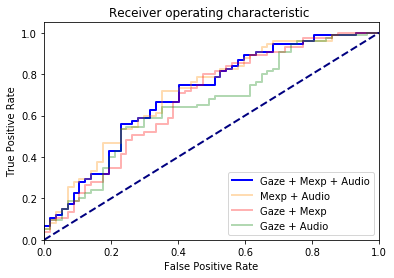

In [66]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(Y_test_mod, li_prob)
roc_auc = auc(fpr, tpr)
print(roc_auc)    
    
    
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='blue',
         lw=lw, label='Gaze + Mexp + Audio' )

plt.plot(roc_curve(Y_test_mod, li_prob_1)[0], roc_curve(Y_test_mod, li_prob_1)[1], color='darkorange',
         lw=lw,alpha=0.3, label='Mexp + Audio')

plt.plot(roc_curve(Y_test_mod, li_prob_2)[0], roc_curve(Y_test_mod, li_prob_2)[1], color='red',
         lw=lw,alpha=0.3, label='Gaze + Mexp')

plt.plot(roc_curve(Y_test_mod, li_prob_3)[0], roc_curve(Y_test_mod, li_prob_3)[1], color='green',
         lw=lw,alpha=0.3, label='Gaze + Audio')



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()